# Welcome to the Cart-Pole Simulation Dashboard

### Importing the necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, HTML
import ipywidgets as widgets

### Defining the necessary functions (Equations of motion, Controllers and etc)

In [ ]:
# Defining the Equations of Motion and Dynamics for simulation

def cart_pendulum_dynamics(y, F, params):
    """
    Cart-pendulum equations. 
    Note: Noise is never introduced through these dynamics
    
    Input:
        y = [x, x_dot, theta, theta_dot]

    Returns:
        [x_dot, x_ddot, theta_dot, theta_ddot]
    """
    M  = params['M']
    m  = params['m']
    l  = params['l'] / 2
    g  = params['g']
    mu_c = params.get('mu_c', 0.01)
    mu_p = params.get('mu_p', 0.001)
    
    x, x_dot, theta, theta_dot = y
    s = np.sin(theta)
    c = np.cos(theta)
    
    x_ddot = (
        m*g*s*c 
        - (7/3)*(F + m*l*(theta_dot**2)*s - mu_c*x_dot)
        - (mu_p * theta_dot * c)/l
    )/(m*c**2 - (7/3)*M)

    theta_ddot = (3/(7*l))*(g*s - x_ddot*c - (mu_p*theta_dot)/(m*l))
    
    return np.array([x_dot, x_ddot, theta_dot, theta_ddot])


# CONTROLLER 1 - Defining the PID controller (For simplicity PD controller is used)

def pid_control_law(y_filt, params, x_ref=0):
    """
    PID control based on filtered measurement 'y_filt'
    
    Input:
        y_filt = [x, x_dot, theta, theta_dot]
        params = {'Kp_x', 'Kd_x', 'Kp_theta', 'Kd_theta'}
        x_ref = reference cart position, default=0

    Returns:
        F = control force
    """
    x, x_dot, theta, theta_dot = y_filt
    
    Kp_x     = params['Kp_x']
    Kd_x     = params['Kd_x']
    Kp_theta = params['Kp_theta']
    Kd_theta = params['Kd_theta']

    # Outer loop: cart position -> desired pendulum angle
    x_error   = x_ref - x
    theta_ref = np.pi + (Kp_x * x_error - Kd_x * x_dot)
    
    # Inner loop: pendulum angle -> force
    theta_error = theta_ref - theta
    F = Kp_theta * theta_error - Kd_theta * theta_dot
    return F

# Controller 2 - ADD ANOTHER CONTROLLER HERE

# LOW PASS FILTER 
def low_pass_filter(old_val, new_meas, alpha=0.05):
    """
    Discrete-time first-order LP filter:
        filtered_{k+1} = alpha * new_measurement + (1 - alpha)*filtered_k
    """
    return alpha*new_meas + (1 - alpha)*old_val


### Defining the discrete simulation

In [ ]:
def simulate_discrete(params, t_final=5.0, dt=0.001,
                      noise_std=[0,0,0,0],
                      alpha=0.05,
                      controller_type='PID',
                      x_ref=0.0):
    """
    Discrete stepping from 0..t_final with step dt.
    Integrate the cart-pendulum dynamics with a given controller.
    Add noise to the measurements.

    Input:
        params = {'M', 'm', 'l', 'g', 'mu_c', 'mu_p', 'Kp_x', 'Kd_x', 'Kp_theta', 'Kd_theta', 'alpha'}
        t_final = final time, default=5.0
        dt = time step, default=0.001
        noise_std = standard deviation of measurement noise
        alpha = LP filter parameter
        controller_type = 'PID' or 'PD' or 'LQR' or 'None'
        x_ref = reference cart position for the controller

    Return:
        t_vals, y_true_array, y_meas_array, y_filt_array
    """
    n_steps = int(t_final / dt)
    t_vals = np.linspace(0, t_final, n_steps+1)

    # initial conditions
    # (you can adapt to your chosen values)
    y0 = np.array([0.0, 0.0, np.deg2rad(90), 0.0])  # e.g., 45 deg initial tilt
    y_true = y0.copy()
    y_filt = y0.copy()  # for the filter’s initial guess

    # For storing the results
    y_true_array = np.zeros((n_steps+1, 4))
    y_meas_array = np.zeros((n_steps+1, 4))
    y_filt_array = np.zeros((n_steps+1, 4))

    y_true_array[0] = y_true
    y_filt_array[0] = y_filt
    # measured is just y_true + noise at t=0:
    y_meas_array[0] = y_true + np.random.normal(0, noise_std)

    for k in range(n_steps):
        # measure (with noise)
        y_meas = y_true + np.random.normal(0, noise_std)

        # filter
        y_filt = low_pass_filter(y_filt, y_meas, alpha)

        # choose control
        if controller_type=='PID':
            F = pid_control_law(y_filt, params, x_ref=x_ref)
        else:
            # For demonstration, no control
            # or you could place LQR, etc.
            F = 0.0

        # integrate one step (simple Euler)
        dydt = cart_pendulum_dynamics(y_true, F, params)
        y_true_next = y_true + dt*dydt

        # store
        y_true_array[k+1] = y_true_next
        y_meas_array[k+1] = y_meas
        y_filt_array[k+1] = y_filt

        # update
        y_true = y_true_next

    return t_vals, y_true_array, y_meas_array, y_filt_array

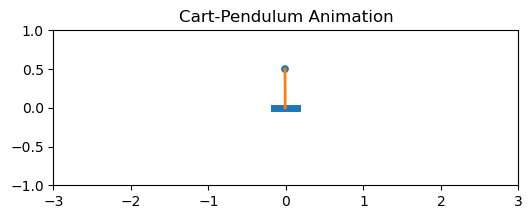

In [12]:

def simulate_discrete(params, t_final=5.0, dt=0.001,
                      noise_std=[0,0,0,0],
                      alpha=0.05,
                      x_ref=0.0):
    """
    Discrete stepping from 0..t_final with step dt.
    Return:
        t_vals, y_true_array, y_meas_array, y_filt_array
    """
    n_steps = int(t_final / dt)
    t_vals = np.linspace(0, t_final, n_steps+1)

    # initial conditions
    # (you can adapt to your chosen values)
    y0 = np.array([0.0, 0.0, params['theta0'], 0.0])  # e.g., 45 deg initial tilt
    y_true = y0.copy()
    y_filt = y0.copy()  # for the filter’s initial guess

    # For storing the results
    y_true_array = np.zeros((n_steps+1, 4))
    y_meas_array = np.zeros((n_steps+1, 4))
    y_filt_array = np.zeros((n_steps+1, 4))

    y_true_array[0] = y_true
    y_filt_array[0] = y_filt
    # measured is just y_true + noise at t=0:
    y_meas_array[0] = y_true + np.random.normal(0, noise_std)

    for k in range(n_steps):
        # measure (with noise)
        y_meas = y_true + np.random.normal(0, noise_std)

        # filter
        y_filt = low_pass_filter(y_filt, y_meas, params['LP alpha'])

        # choose control'
        if params['controller_type']=='PID':
            F = pid_control_law(y_filt, params, x_ref=x_ref)
        else:
            # For demonstration, no control
            # or you could place LQR, etc.
            F = 0.0

        # integrate one step (simple Euler)
        dydt = cart_pendulum_dynamics(y_true, F, params)
        y_true_next = y_true + dt*dydt

        # store
        y_true_array[k+1] = y_true_next
        y_meas_array[k+1] = y_meas
        y_filt_array[k+1] = y_filt

        # update
        y_true = y_true_next

    return t_vals, y_true_array, y_meas_array, y_filt_array


###############################
# 2) Plotting & Animation
###############################
def animate_pendulum(t_vals, sol, params):
    """
    Create and return an animation object inline (for Jupyter).
    sol is shape (4, N) with:
        sol[0,:] = x-positions
        sol[2,:] = theta
    """
    x_vals = sol[0,:]
    theta_vals = sol[2,:]
    l = params['l']

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_xlim([-3, 3])
    ax.set_ylim([-1.0, 1.0])
    ax.set_aspect('equal')
    ax.set_title("Cart-Pendulum Animation")

    cart_width = 0.3
    cart_line, = ax.plot([], [], lw=5)
    rod_line, = ax.plot([], [], lw=2)
    bob_circle = plt.Circle((0,0), 0.05)
    ax.add_patch(bob_circle)

    def init():
        cart_line.set_data([], [])
        rod_line.set_data([], [])
        bob_circle.set_center((0, 0))
        return (cart_line, rod_line, bob_circle)

    def update(frame):
        x = x_vals[frame]
        theta = theta_vals[frame]

        # cart
        cart_line.set_data([x - cart_width/2, x + cart_width/2], [0, 0])

        # rod
        rod_x = [x, x + l*np.sin(theta)]
        rod_y = [0, -l*np.cos(theta)]
        rod_line.set_data(rod_x, rod_y)

        bob_circle.set_center((rod_x[1], rod_y[1]))
        return (cart_line, rod_line, bob_circle)

    dt_ms = 1000*(t_vals[1]-t_vals[0]) if len(t_vals)>1 else 20
    anim = animation.FuncAnimation(
        fig, update, frames=len(t_vals),
        init_func=init, blit=True,
        interval=dt_ms
    )
    return anim

###############################
# 3) Build the interactive UI
###############################

# Sliders for PID
Kp_x_slider = widgets.FloatSlider(
    value=1.54, min=0.0, max=20.0, step=0.01,
    description='Kp_x'
)
Kd_x_slider = widgets.FloatSlider(
    value=0.84, min=0.0, max=20.0, step=0.01,
    description='Kd_x'
)
Kp_theta_slider = widgets.FloatSlider(
    value=18.36, min=0.0, max=20.0, step=0.01,
    description='Kp_theta'
)
Kd_theta_slider = widgets.FloatSlider(
    value=0.81, min=0.0, max=20.0, step=0.01,
    description='Kd_theta'
)

# Checkboxes for showing noise and filtered data
show_noise_checkbox = widgets.Checkbox(
    value=True,
    description='Show Noisy Measurement'
)
show_filter_checkbox = widgets.Checkbox(
    value=True,
    description='Show Filtered Measurement'
)

# Toggle for controller type
controller_selector = widgets.ToggleButtons(
    options=['PID', 'Pole Placement', 'None'],
    description='Controller:',
    value='PID'
)

# Sliders for noise levels (cart pos & theta, just as example)
noise_x_slider = widgets.FloatSlider(
    value=0.01, min=0.0, max=0.1, step=0.001,
    description='Noise_x'
)
noise_theta_slider = widgets.FloatSlider(
    value=0.01, min=0.0, max=0.1, step=0.001,
    description='Noise_theta'
)

# Low-pass alpha slider
alpha_slider = widgets.FloatSlider(
    value=0.5, min=0.0, max=1.0, step=0.01,
    description='LP alpha'
)

theta_slider = widgets.FloatSlider(
    value=90, min=0.0, max=360.0, step=0.1,
    description='theta0'
)

# Button to trigger everything
run_button = widgets.Button(
    description="Animate",
    button_style='success'  # 'success', 'info', 'warning', 'danger' or ''
)
run_button._click_handlers.callbacks = []  # Clears existing callbacks

# An output widget to hold the results
output = widgets.Output()

######################################
# 4) The callback for the "Animate" button
######################################

def on_run_button_clicked(b):
    with output:
        # Clear previous output each time
        output.clear_output(wait=True)

        # 1) Gather parameters from widgets
        params = {
            'M':  1.0,
            'm':  0.2,
            'l':  0.5,
            'g':  9.81,
            'Kp_x':     Kp_x_slider.value,
            'Kd_x':     Kd_x_slider.value,
            'Kp_theta': Kp_theta_slider.value,
            'Kd_theta': Kd_theta_slider.value,
            'LP alpha': alpha_slider.value,
            'controller_type': controller_selector.value,
            'theta0': np.deg2rad(theta_slider.value)
        }
        noise_std = [
            noise_x_slider.value,  # x
            0.0,                   # x_dot
            noise_theta_slider.value,  # theta
            0.0                    # theta_dot
        ]

        # 2) Run simulation
        t_vals, y_true, y_meas, y_filt = simulate_discrete(
            params=params,
            t_final=5.0,
            dt=0.01,
            noise_std=noise_std
        )

        # 3) Generate the time-series plots
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 8))

        # First subplot: cart position
        ax1.plot(t_vals, y_true[:,0], label='True x')
        ax1.plot(t_vals, y_meas[:,0], ':', label='Noisy x')
        ax1.plot(t_vals, y_filt[:,0], '--', label='Filtered x')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Cart Position (m)')
        ax1.legend()
        ax1.set_title("Cart Position vs Time")

        # Second subplot: pendulum angle
        ax2.plot(t_vals, np.rad2deg(y_true[:,2]), label='True theta (deg)')
        ax2.plot(t_vals, np.rad2deg(y_meas[:,2]), ':', label='Noisy theta')
        ax2.plot(t_vals, np.rad2deg(y_filt[:,2]), '--', label='Filtered theta')
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Angle (deg)')
        ax2.legend()
        ax2.set_title("Pendulum Angle vs Time")

        plt.tight_layout()
        plt.show()

        # 4) Animate
        # The animate_pendulum function expects shape (4, N)
        sol = y_true.T  # shape (4, N) with [x, x_dot, theta, theta_dot]
        # display animation inline
        _ = display(HTML(animate_pendulum(t_vals, sol, params).to_jshtml()))

        return None

run_button.on_click(on_run_button_clicked)

######################################
# 5) Display the UI
######################################
start_box = widgets.VBox([
    widgets.HTML(value="<b>Starting parameters</b>"),
    widgets.HBox([theta_slider, widgets.Label(value="Degrees")]),
])

pid_box = widgets.VBox([
    widgets.HTML(value="<b>PID Settings</b>"),
    widgets.HBox([Kp_x_slider, Kd_x_slider]),
    widgets.HBox([Kp_theta_slider, Kd_theta_slider]),
])

noise_box = widgets.VBox([
    widgets.HTML(value="<b>PID Settings</b>"),
    widgets.HBox([noise_x_slider, noise_theta_slider]),
])

filter_box = widgets.VBox([
    widgets.HTML(value="<b>PID Settings</b>"),
    alpha_slider,
    widgets.HBox([show_noise_checkbox, show_filter_checkbox]),
])

dashboard = widgets.VBox([
    start_box,
    pid_box,
    noise_box,
    filter_box,
    controller_selector,
    widgets.HBox([
        run_button,
        widgets.Label(value="Please allow for animation to render, should only take a few seconds.")
    ]),
    output
])

display(dashboard)
